# A/B Project for Membership in a Gym
***

## Introduction

### Import the dataset

- Import the libraries
- Import the four csv files as pandas DataFrames and examine them. 

In [1]:
#Import the libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

%matplotlib inline

### Join all of your data

It would be helpful to have a single DataFrame with all of this data. 

Create a DataFrame containing all of this data. Keep in mind that not all visits in **visits.csv** occurred during the A/B test. Lets only pull data where `visit_date` is on or after 7-1-17.

In [2]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)

In [3]:
from glob import glob
# Get all the csv files
csv_files = glob("*.{}".format("csv"))

# display the shape of each csv file
shape = [pd.read_csv(f).shape for f in csv_files]
print(f"The shape of each csv file {shape}")

# Checking for number of matching columns in the files
matching = [set(pd.read_csv(f).columns) for f in csv_files]
pattern = set.intersection(*matching)

print("The total number of matching columns: {}".format(len(pattern)))
print("The names of the columns are: {}".format(list(pattern)))

# Lets join the columns using merge. Grabbing all the csv files.
visits = pd.read_csv("./visits.csv")
fitness_tests = pd.read_csv("./fitness_tests.csv")
applications = pd.read_csv("./applications.csv")
purchases = pd.read_csv("./purchases.csv")

# Perform the first join between visits and fitness_tests
df1 = pd.merge(visits, fitness_tests, on=list(pattern), how='left')

# Perform the second join with applications
df2 = pd.merge(df1, applications, on=list(pattern), how='left')

# Perform the final join with purchases
result = pd.merge(df2, purchases, on=list(pattern), how='left')

# Select only the required columns
df = result[['first_name', 'last_name', 'gender', 'email', 'visit_date', 
                 'fitness_test_date', 'application_date', 'purchase_date']]

# Confirm the number of rows
print(f"Number of rows in the resulting DataFrame: {len(result)}")

# Filter rows based on date
df["visit_date"] = pd.to_datetime(df["visit_date"],format="%m-%d-%y")
df = df.loc[df["visit_date"] >= "07-01-17"]
print(f"Shape in the resulting DataFrame after filtering date: {df.shape}")


The shape of each csv file [(575, 5), (2500, 5), (450, 5), (6000, 5)]
The total number of matching columns: 4
The names of the columns are: ['last_name', 'gender', 'first_name', 'email']
Number of rows in the resulting DataFrame: 6004
Shape in the resulting DataFrame after filtering date: (5004, 8)


### Visualize the Groups

Having compiled the DataFrame we can use to begin our project.

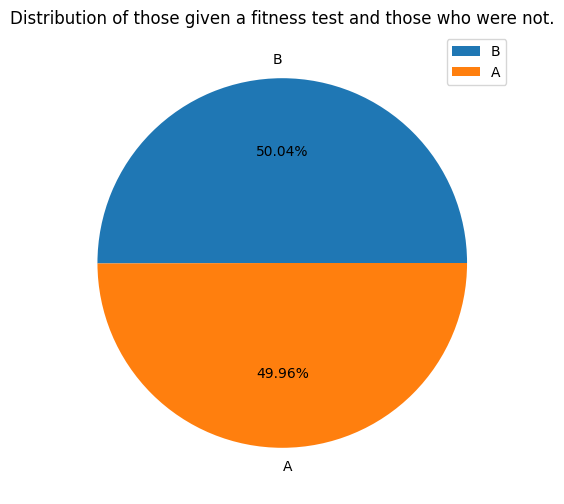

In [4]:
# Create a count of True and False of those who recieved a fitness test and those who didnt.
count_fitness_test = df[["fitness_test_date"]].isna().value_counts()

fig,ax = plt.subplots(figsize=(10,6))
ax.pie(count_fitness_test, labels=['B', 'A'], autopct='%0.2f%%')

plt.title("Distribution of those given a fitness test and those who were not.")
plt.legend()
plt.show()
plt.close()


##### Creating a chi square contingency test on gender and fitness test taken.

Recall that the sign-up process for MuscleHub has several steps:

1. Take a fitness test with a personal trainer (only Group A).
2. Fill out an application for the gym.
3. Send in their payment for their first month's membership.

Determine the percentage of people in each group who complete Step 2, filling out an application.

In [6]:
# Creating a column where yes=Application and nan=No application
df["application_filled"] = np.where(pd.notna(df['application_date']), 'Application', 'No Application')

# Defining group A and group B based on fitness test taken
df["a/b_fitness_test"] = np.where(pd.notna(df["fitness_test_date"]),"A", "B")

# Grouping data of both columns
app_counts = df.groupby(["application_filled","a/b_fitness_test"])["first_name"].count().reset_index()

application_df = pd.DataFrame(app_counts,columns=["application_filled","a/b_fitness_test","first_name"]).rename({"first_name":"count"},axis=1)
application_df

,application_filled,a/b_fitness_test,count
0,Application,A,250
1,Application,B,325
2,No Application,A,2254
3,No Application,B,2175


In [7]:
app_pivot = application_df.pivot(index="a/b_fitness_test",columns="application_filled",values="count").reset_index()
app_pivot["sum_is_application"] = app_pivot["Application"] + app_pivot["No Application"]
app_pivot["percentage_is_application"] = np.round((app_pivot["Application"]/app_pivot["sum_is_application"]).multiply(100),2)
app_pivot

application_filled,a/b_fitness_test,Application,No Application,sum_is_application,percentage_is_application
0,A,250,2254,2504,9.98
1,B,325,2175,2500,13.00


It looks like more people from Group B turned in an application. 
We need to know if this difference is statistically significant.
Lets calculate the percentage of people in each group who complete an application

## Calculate the statistical significance of applications

Having calculated the difference in who turned in an application between groups, determine if this difference is statistically significant.

$$ \chi^2 $$  
test for independence can tell us how likely it is that random chance can explain any observed difference between the actual frequencies in the data and these theoretical expectations.

In [8]:
# Calculate the chi2_contingency independence test
def contingency_test(dataset:pd.DataFrame, *cols, significance_val):
    x = np.array([dataset[cols[0]],dataset[cols[1]]])
    contingency = np.stack(x,axis=-1)
    chi2_stat, pvalue,dof,expected = chi2_contingency(contingency)
    print("The chi2 statistic: {} \nthe p-value of the data: {}".format(chi2_stat,pvalue))

    # Significance level
    if significance_val > pvalue:
        print("Null Hypothesis to be rejected.")
    else:
        print("Null hypothesis not to be rejected")
        
contingency_test(app_pivot,"Application","No Application",significance_val=0.05)

The chi2 statistic: 10.893961295282612 
the p-value of the data: 0.0009647827600722302
Null Hypothesis to be rejected.



The two main results of a chi-square test are the chi-square statistic and the p-value. The chi-square statistic quantifies how far the observed data deviates from the expected distribution. When compared against the standard chi-square distribution, this measure translates to a p-value which gives the statistical significance of the deviation from the expected distribution. A p-value less than the significance level (e.g., 0.05) means you reject the null hypothesis.

## Detemine the count of memberships from applications

It looks like people who took the fitness test were more likely to purchase a membership if they picked up an application. Why might that be?

In [ ]:
# First lets create a column of those who are members and not members. Then filter out those who filled the application/picked it.
df["is_member"] = np.where(pd.notna(df["purchase_date"]),"Member","Not Member")
just_apps = df[df["application_filled"]=="Application"]

# repeating the process in application for A and B groups. Creating groups for member and not member.
grp_members = just_apps.groupby(["a/b_fitness_test","is_member"])["first_name"].count().reset_index().rename({"first_name":"count"},axis=1)
final_membership = grp_members.pivot(index="a/b_fitness_test",columns="is_member",values="count").reset_index()

final_membership["total"] = final_membership["Member"] + final_membership["Not Member"]
final_membership["percent_purchase"] = (final_membership["Member"]/final_membership["total"]).multiply(100)
final_membership


is_member,a/b_fitness_test,Member,Not Member,total,percent_purchase
0,A,200,50,250,80.000000
1,B,250,75,325,76.923077


In [68]:
df["is_gender"] = np.where(df["gender"]=="male","M","F")
gender = df.groupby(["a/b_fitness_test","is_member","is_gender"])["first_name"].count().reset_index().rename({"first_name":"count"},axis=1)
gender = gender.pivot(index="a/b_fitness_test",columns=["is_member","is_gender"],values="count").reset_index()

gender["Member_total"] = gender["Member"]["F"]+gender["Member"]["M"]
gender["Not_Member_total"] = gender["Not Member"]["F"]+gender["Not Member"]["M"]
gender["grand_total"] = gender["Member_total"]+gender["Not_Member_total"]
gender["percent_purchase"] = (gender["Member_total"]/gender["grand_total"]).multiply(100)
gender

is_member a/b_fitness_test Member      Not Member       Member_total  \
is_gender                       F    M          F     M                
0                        A     96  104       1159  1145          200   
1                        B    133  117       1176  1074          250   

is_member Not_Member_total grand_total percent_purchase  
is_gender                                                
0                     2304        2504          7.98722  
1                     2250        2500         10.00000

In [69]:
# Calculate the chi2_contingency independence test
# Calling the function created above
contingency_test(gender,"Member_total","Not_Member_total",significance_val=0.05)

The chi2 statistic: 5.949182292591156 
the p-value of the data: 0.014724114645783203
Null Hypothesis to be rejected.


## Calculate the statistical significance of memberships

Calculate if the difference between the following groups is statistically significant: 
- The customers that picked up an application and took a fitness test.
- The customers that did not take a fitness test and picked up an application.

In [10]:
# Calculate the chi2_contingency independence test
# Calling the function created above
contingency_test(final_membership,"Member","Not Member",significance_val=0.05)

The chi2 statistic: 0.615869230769231 
the p-value of the data: 0.43258646051083327
Null hypothesis not to be rejected


## Detemine the count of all memberships

Previously, you looked at what percentage of people who picked up applications purchased memberships. 

Now, determine what percentage of ALL visitors purchased memberships. 

In [11]:
# Percentage of all visitors
# df.head()

all_visitors = df.groupby(["a/b_fitness_test","is_member"])["first_name"].count().reset_index().rename({"first_name":"count"},axis=1)
all_visitors = all_visitors.pivot(index="a/b_fitness_test",columns="is_member",values="count").reset_index()
all_visitors["total"] = all_visitors["Member"]+all_visitors["Not Member"]
all_visitors["percentage_purchase"] = (all_visitors["Member"]/all_visitors["total"]).multiply(100)
all_visitors

is_member,a/b_fitness_test,Member,Not Member,total,percentage_purchase
0,A,200,2304,2504,7.98722
1,B,250,2250,2500,10.00000


## Calculate the statistical significance between groups

Determine if there is a significant difference in memberships between Group A and Group B.

In [12]:
# Calculate the chi2_contingency independence test
# Calling the function created above
contingency_test(all_visitors,"Member","Not Member",significance_val=0.05)

The chi2 statistic: 5.949182292591156 
the p-value of the data: 0.014724114645783203
Null Hypothesis to be rejected.


## Visualize the results

Create visualizations for Janet that show the difference between Group A (people who were given the fitness test) and Group B (people who were not given the fitness test) at each state of the process:

- Percent of visitors who apply.
- Percent of applicants who purchase a membership.
- Percent of visitors who purchase a membership.

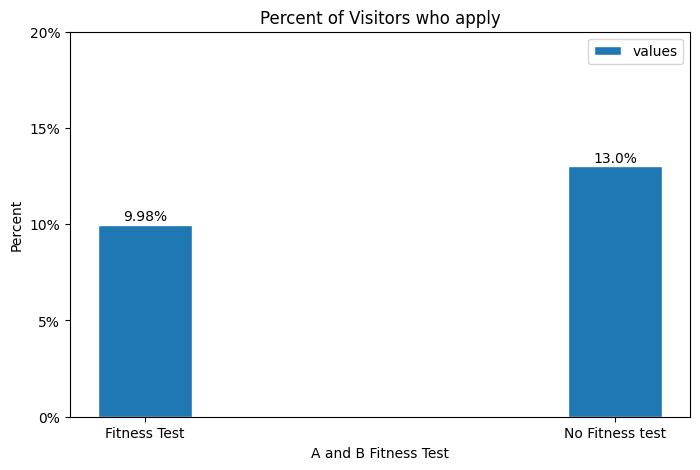

In [16]:
# Data
bar_width=0.2
datasize = np.arange(len(app_pivot))
tick_range = np.arange(0,25,5)

# Plotting
fig,ax = plt.subplots(figsize=(8,5))
bars = ax.bar(datasize,app_pivot["percentage_is_application"].values,width=bar_width,edgecolor="white",label="values")

# Adding the details
ax.set_title("Percent of Visitors who apply")
ax.set_xticks(datasize)
ax.set_xticklabels(["Fitness Test","No Fitness test"])
ax.set_yticks(tick_range,labels=[str(n)+"%" for n in tick_range])
ax.set_ylabel("Percent")
ax.set_xlabel("A and B Fitness Test")
ax.legend()

# Loop through the bars and add annotations
for bar in bars:
   height = bar.get_height()
   ax.annotate(f'{height}%', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 1),
   textcoords="offset points", ha='center', va='bottom')

#Displaying the plot
plt.show()
plt.close()

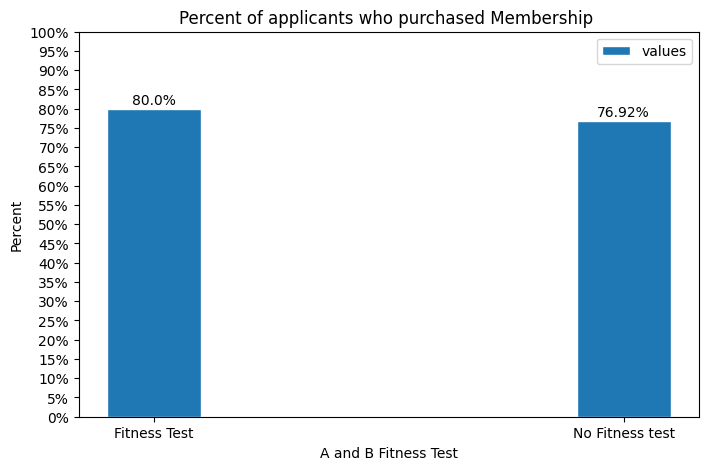

In [20]:
# Data
bar_width=0.2
datasize = np.arange(len(final_membership))
tick_range = np.arange(0,105,5)

# Plotting
fig,ax = plt.subplots(figsize=(8,5))
bars = ax.bar(datasize,final_membership["percent_purchase"].values,width=bar_width,edgecolor="white",label="values")

# Adding the details
ax.set_title("Percent of applicants who purchased Membership ")
ax.set_xticks(datasize)
ax.set_xticklabels(["Fitness Test","No Fitness test"])
ax.set_yticks(tick_range,labels=[str(n)+"%" for n in tick_range])
ax.set_ylabel("Percent")
ax.set_xlabel("A and B Fitness Test")
ax.legend()

# Loop through the bars and add annotations
for bar in bars:
   height = bar.get_height()
   ax.annotate(f'{round(height,2)}%', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 1),
   textcoords="offset points", ha='center', va='bottom')

#Displaying the plot
plt.show()
plt.close()

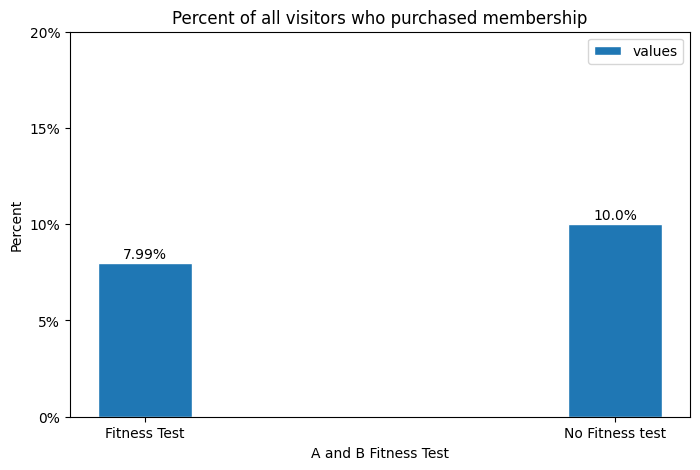

In [25]:
# Data
bar_width=0.2
datasize = np.arange(len(all_visitors))
tick_range = np.arange(0,25,5)

# Plotting
fig,ax = plt.subplots(figsize=(8,5))
bars = ax.bar(datasize,all_visitors["percentage_purchase"].values,width=bar_width,edgecolor="white",label="values")

# Adding the details
ax.set_title("Percent of all visitors who purchased membership")
ax.set_xticks(datasize)
ax.set_xticklabels(["Fitness Test","No Fitness test"])
ax.set_yticks(tick_range,labels=[str(n)+"%" for n in tick_range])
ax.set_ylabel("Percent")
ax.set_xlabel("A and B Fitness Test")
ax.legend()

# Loop through the bars and add annotations
for bar in bars:
   height = bar.get_height()
   ax.annotate(f'{round(height,2)}%', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 1),
   textcoords="offset points", ha='center', va='bottom')

#Displaying the plot
plt.show()
plt.close()

Create a [wordcloud](https://pypi.org/project/wordcloud/) visualization to create an ad for the MuscleHub Gym with the data in `interviews.txt`. 

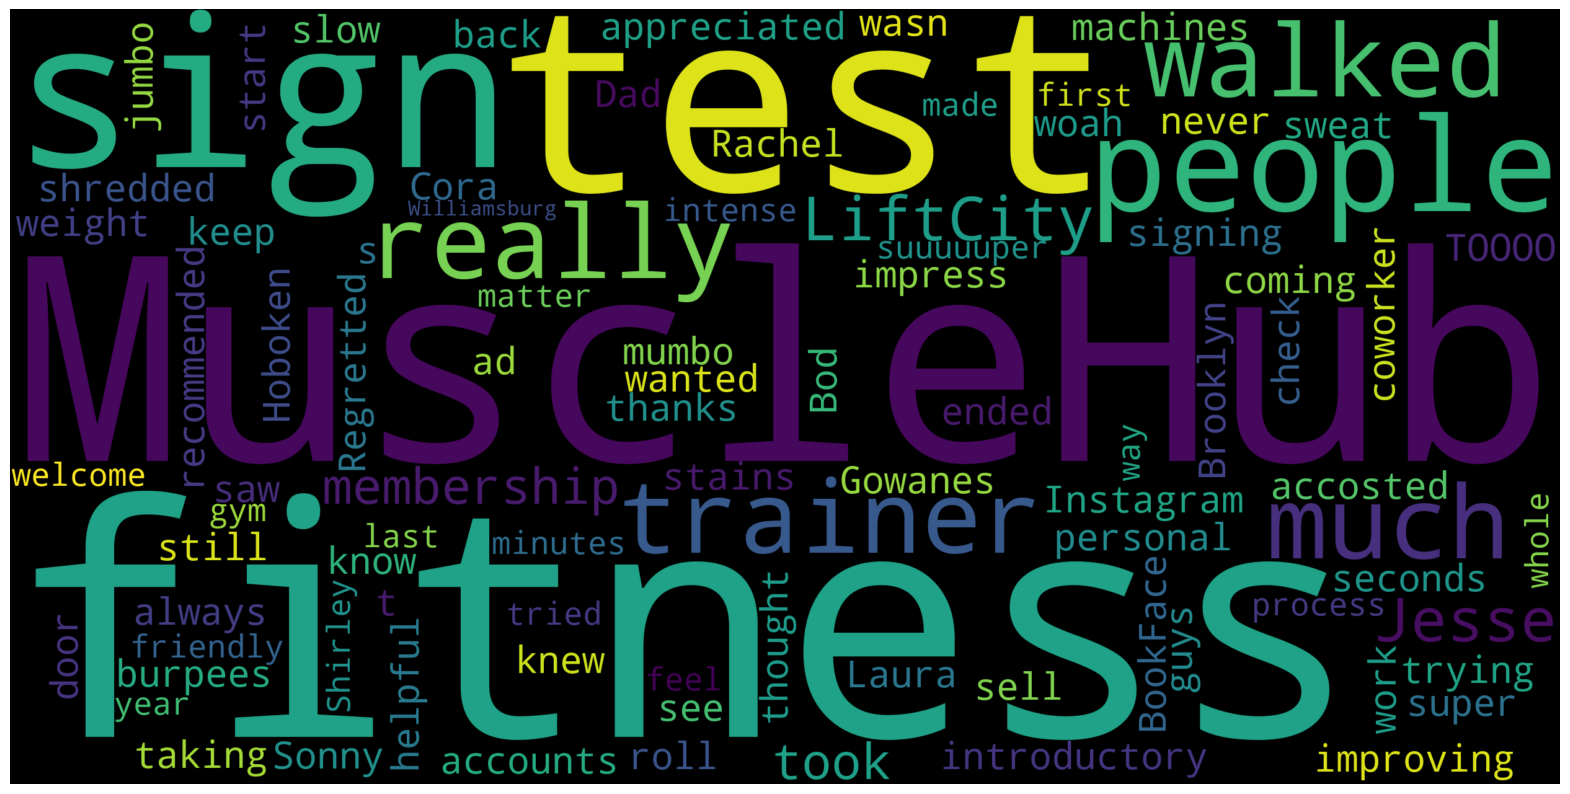

In [23]:
# Import modules
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator # for creating wordclouds
from collections import Counter  # for counting objects
from matplotlib.pyplot import figure # to create a figure in matplotlib

txtContent = ""
# Open and read the interviews.txt file
with open("interviews.txt","r",encoding='utf-8') as f:
    txtContent += f.read()
# interviews = open(r"interviews.txt", encoding='utf8')
# txtContent = interviews.read()
# print("The Content of text file is : ", txtContent)

# Create a wordcloud object
wordcloud = WordCloud(width=2500, height=1250).generate(txtContent)

# Display the wordcloud with MatplotLib and save figure
figure(num=None, figsize=(20, 16), facecolor='w', edgecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
